In [47]:
import csv
import xmltodict
import pandas as pd
# Reading xml file
with open("data/original_input/ccs_acm_ccs2012.xml") as file:
    filedata = file.read()
import warnings
warnings.filterwarnings("ignore")
# Converting xml to python dictionary (ordered dict)
data_dict = xmltodict.parse(filedata)

## Step 1 convert xml file to pair-wise structure dataset

In [48]:
concept_id=[]
concept_name=[]
child_pair=[]
group_code=[]
for i in range(len(data_dict['rdf:RDF']['skos:Concept'])):

    id_=data_dict['rdf:RDF']['skos:Concept'][i]['@rdf:about'][-8:]
    if id_=='10010600' or id_=='10010633':
        print(data_dict['rdf:RDF']['skos:Concept'][i])
    concept_id.append(id_)
    concept_name.append(data_dict['rdf:RDF']['skos:Concept'][i]['skos:prefLabel']['#text'])
    try: 
        len_child=len(data_dict['rdf:RDF']['skos:Concept'][i]['skos:narrower'])
    except:
        len_child=0
    if len_child>1:
        list_child=[]
        for list_id in [data_dict['rdf:RDF']['skos:Concept'][i]['skos:narrower'][j]['@rdf:resource'] for j in range(len_child)]:
            if id_ in list_id:
                list_child.append(list_id[-8:])
            
        child_pair.append(list_child)
    elif len_child==1:
        
        child_pair.append(data_dict['rdf:RDF']['skos:Concept'][i]['skos:narrower']['@rdf:resource'][-8:])
        
    else:
        child_pair.append([])
    group=data_dict['rdf:RDF']['skos:Concept'][i][list(data_dict['rdf:RDF']['skos:Concept'][i].keys())[2]]['@rdf:resource']
    if len(group)<8:
        group_code.append(id_)
    else:
        group_code.append(group[:8])

OrderedDict([('@rdf:about', '10010583.10010600'), ('skos:prefLabel', OrderedDict([('@lang', 'en'), ('#text', 'Integrated circuits')])), ('skos:broader', OrderedDict([('@rdf:resource', '10010583')])), ('skos:narrower', [OrderedDict([('@rdf:resource', '10010583.10010600.10010601')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010602')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010607')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010612')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010615')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010628')])])])
OrderedDict([('@rdf:about', '10010583.10010633'), ('skos:prefLabel', OrderedDict([('@lang', 'en'), ('#text', 'Very large scale integration design')])), ('skos:broader', OrderedDict([('@rdf:resource', '10010583')])), ('skos:narrower', [OrderedDict([('@rdf:resource', '10010583.10010633.10010601')]), OrderedDict([('@rdf:resource', '10010583.10010633.10010634')]), OrderedDict([('@rdf:resource', 

In [49]:
acm_css = pd.DataFrame(
    {'concept_id': concept_id,
     'concept_name': concept_name,
     'child_pair': child_pair,
     'group_code':group_code
    })


In [50]:
acm_css.to_csv('acm_css.csv')

In [51]:
import numpy as np
df_pair=acm_css.explode('child_pair')
df_pair.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3782 entries, 0 to 2112
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   concept_id    3782 non-null   object
 1   concept_name  3782 non-null   object
 2   child_pair    2100 non-null   object
 3   group_code    3782 non-null   object
dtypes: object(4)
memory usage: 147.7+ KB


In [52]:
df_res=df_pair.merge(df_pair[['concept_id','concept_name']].drop_duplicates('concept_id'),left_on='child_pair',right_on='concept_id',how='left')

In [53]:
df_final=df_res[['concept_id_x', 'concept_name_x', 'child_pair', 'concept_name_y', 'group_code']]

In [54]:
df_final.columns=['concept_id', 'concept_name', 'child_id',  'child_name','group_code']

In [55]:
df_final=df_final.dropna(subset=['child_id'])

In [56]:
df_final

,concept_id,concept_name,child_id,child_name,group_code
0,10002944,General and reference,10011122,Document types,10002944
1,10002944,General and reference,10011123,Cross-computing tools and techniques,10002944
2,10002950,Mathematics of computing,10003624,Discrete mathematics,10002950
3,10002950,Mathematics of computing,10003648,Probability and statistics,10002950
4,10002950,Mathematics of computing,10003705,Mathematical software,10002950
...,...,...,...,...,...
3665,10010957,Process management,10010964,Power management,10011007
3666,10010957,Process management,10011678,Process synchronization,10011007
3667,10010965,Communications management,10010966,Buffering,10011007
3668,10010965,Communications management,10010967,Input / output,10011007


## Step 2 Split Trees to Subtrees from root level

In [57]:
df_final.group_code.value_counts()

10002951    323
10010147    276
10010583    224
10003752    223
10011007    215
10010405    160
10002950    148
10003456    138
10003120    118
10003033    117
10002978     78
10010520     61
10002944     19
Name: group_code, dtype: int64

In [58]:
list(df_final.group_code.unique())

['10002944',
 '10002950',
 '10002951',
 '10002978',
 '10003033',
 '10003120',
 '10003456',
 '10003752',
 '10010147',
 '10010405',
 '10010520',
 '10010583',
 '10011007']

In [59]:
df_network=df_final

In [60]:

import networkx as nx
def split_group(df_network):
    f_pair_list=[]
    for g in list(df_network.group_code.unique()):
        num_i=len(df_network[df_network.group_code==g])
        if num_i>70:
            new_roots=list(df_network[df_network.concept_id==g].child_name.unique())
            df_group=df_network.drop(df_network[df_network.concept_id==g].index)
            G = nx.from_pandas_edgelist(df_group, 'concept_name', 'child_name', create_using=nx.DiGraph)
            counter=1

            for root in new_roots:
                group=list(nx.dfs_edges(G, source=root))
                if len(group)>1:
                    update_g_code= [list(tup)+[str(g)+"_"+str(counter)] for tup in group]
                    f_pair_list=f_pair_list+update_g_code
                    counter+=1
    df_new_pairs = pd.DataFrame(f_pair_list, columns=['parent_name','child_name','group'])
    return df_new_pairs
        
        

In [61]:
df_new_pairs=split_group(df_network)

## Step 3 Clean duplicates relationships/ subtrees

In [62]:
df_new_pairs.group.value_counts()

10002951_1    87
10010147_4    86
10011007_1    86
10010147_3    82
10011007_2    75
              ..
10010147_7     4
10002978_8     4
10002950_3     3
10010147_8     2
10010583_1     2
Name: group, Length: 77, dtype: int64

In [63]:
df_dup = df_new_pairs[df_new_pairs.duplicated(subset=['parent_name','child_name'], keep=False)]
df_non_dup=df_new_pairs[~df_new_pairs.duplicated(subset=['parent_name','child_name'], keep=False)]

In [64]:
df_dup.parent_name.value_counts()

Collaborative and social computing systems and tools    16
Electronic commerce                                     16
Continuous optimization                                 16
Parallel algorithms                                     10
Network security                                        10
Reinforcement learning                                  10
Enterprise information systems                          10
Optimization with randomized search heuristics           8
Mathematical optimization                                8
Calculus                                                 6
Markup languages                                         6
Non-parametric optimization                              4
Mixed discrete-continuous optimization                   4
Kernel methods                                           4
Social engineering attacks                               4
Discrete optimization                                    4
Name: parent_name, dtype: int64

In [65]:
def clean_dup(df_dup):
    list_group=[]
    for item in list(df_dup.parent_name.unique()):
        df_i=df_dup[df_dup.parent_name==item]
        max_g=len(df_dup)
        group_k=""
        for g in  list(df_i.group.unique()):
            num=len(df_i[df_i.group==g])
            if max_g>num:
                max_g=num
                group_k=g
        list_group.append(group_k)

    df_clean_g=df_dup[df_dup.group.isin(set(list_group))]
    return df_clean_g
            

In [66]:
df_clean_g=clean_dup(df_dup)

In [67]:
df_clean_f = pd.concat([df_non_dup, df_clean_g], ignore_index=True, sort=False)


In [68]:
df_clean_f.to_csv('data/train/acm_ccs_clean.csv')

## Step 4: Dataset split
### Please note, this step we randomly shuffle to get trian, test, validate datasets. Make sure your test dataset is algin with trained model.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
val_ratio = 0.15
test_ratio = 0.15

In [70]:
df=df_clean_f

(array([27., 15., 11.,  6.,  2.,  3.,  3.,  2.,  3.,  4.]),
 array([ 2. , 10.5, 19. , 27.5, 36. , 44.5, 53. , 61.5, 70. , 78.5, 87. ]),
 <BarContainer object of 10 artists>)

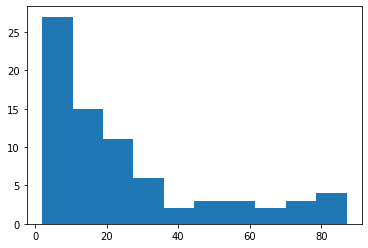

In [71]:
counts = df['group'].value_counts()
plt.hist(counts)

In [72]:
# Since the distribution is skewed, we separate the groups into four parts, and split each of them independently
# into train, validation, and test sets.
splits = [[], [], [], []]
for group, count in counts.items():
    if count <= 20:
        splits[0].append(group)
    elif count <= 40:
        splits[1].append(group)
    elif count <= 60:
        splits[2].append(group)
    else:
        splits[3].append(group)

In [73]:
train_groups = []
val_groups = []
test_groups = []

for split in splits:
    random.shuffle(split)
    length = len(split)
    train_length = int(length * (1 - val_ratio - test_ratio))
    val_length = int(length * val_ratio)
    test_length = int(length * test_ratio) 

    train = split[:train_length]
    val = split[train_length:train_length + val_length]
    test = split[train_length + val_length:]

    train_groups.extend(train)
    val_groups.extend(val)
    test_groups.extend(test)

In [74]:
len(train_groups)

51

In [75]:
len(val_groups)

10

In [76]:
def assign_split(group):
    if group in train_groups:
        return 'train'
    elif group in val_groups:
        return 'val'
    elif group in test_groups:
        return 'test'
    else:
        return 'error'
df['type'] = df['group'].apply(assign_split)

In [77]:
df.columns=['parent','child','group','type']

In [78]:
df.to_csv('data/train/acm_ccs_clean.csv', index=None)

## Step 5: Test Dataset generation (with false relations)

In [80]:
def flase_gen_v2(df):
    list_pair=[]
    list_group=[]
    list_node=[]
    for num in list(pd.unique(df.group)):
        df_test=df[df.group==num][['parent','child']]
        list_check=list(pd.unique(df_test[['parent', 'child']].values.ravel('K')))
        for i in list_check:
            list_node.append(i)
            list_pair.append([x for x in list_check if x != i])
            list_group.append(num)
    df_res= pd.DataFrame(
      {'parent': list_node,
      'child': list_pair,
      'group': list_group
      })
    df_f=df_res.explode('child').dropna()
    df_f_res=df_f[~df_f.duplicated(subset=['parent','child'], keep=False)]
    df['flag']='True'
    df_input=df_f_res.merge(df[['parent','child','flag']],on=['parent','child'],how='left')
    df_input.flag=df_input.flag.fillna('False')
    return df_input

In [85]:
df=pd.read_csv('data/train/acm_ccs_clean.csv')

In [81]:
df.type.value_counts()

train    1194
test      412
val       273
Name: type, dtype: int64

In [82]:
df_test_i=df[df['type']=='test']

In [83]:
df_test=flase_gen_v2(df_test_i)

In [84]:
df_test.to_csv('data/evaluation/ccs_test.csv')